### imports

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

import numpy as np
import pandas as pd
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV
)
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    auc,
    roc_curve,
    log_loss
)
from statsmodels.stats.outliers_influence import variance_inflation_factor
import random
import warnings

#Homebrew 
import sys
sys.path.append('./functions')
from functions import (
    logistic_regression_diagnostic_plots,
    diagnostic_plots,
    calculate_vif,
    remove_high_vif_features,
    evaluate,
    plot_sensitivity_specificity,
    aic_scorer,
    select_model_by_aic,
    view_logistic_regression_coefficients,
    calculate_cooks_distance
)

### Data Loading

In [2]:
df_train = pd.read_excel('./data/BBBC-Train.xlsx')
df_train = df_train.set_index('Observation')
df_test = pd.read_excel('./data/BBBC-Test.xlsx')
df_test = df_test.set_index('Observation')
y_train = df_train['Choice']
X_train = df_train.drop('Choice',axis=1)
y_test = df_test['Choice']
X_test = df_test.drop('Choice',axis=1)

#### Balanced dataset for SVM

In [3]:
ones = df_train[df_train['Choice']==0]
zeros = df_train[df_train['Choice']==1]

# Randomly sample 400 rows from the ones
ones_sample = ones.sample(n=len(zeros), random_state=42)  # random_state for reproducibility

# Concatenate the sampled ones with the zeros to form a balanced dataset
bal_df = pd.concat([ones_sample, zeros], ignore_index=False)
bal_X_train = bal_df.drop('Choice',axis=1)
bal_y_train = bal_df['Choice']

In [4]:
# balanced (same num of 1s and 0s in choice)
import numpy as np

# Assuming 'heart' is a pandas DataFrame
n_samples = len(ones) # Number of rows in the DataFrame

# Calculate the number of samples to select (70% of the dataset)
n_train_samples = 400

# Generate random indices without replacement
index_selector = np.random.choice(n_samples, n_train_samples, replace=False)

# tr_ind now contains the indices of the rows to use for training


In [5]:
dict_results_lists = []

In [6]:
X_train.head()

,Gender,Amount_purchased,Frequency,Last_purchase,First_purchase,P_Child,P_Youth,P_Cook,P_DIY,P_Art
Observation,,,,,,,,,,
1,1,113,8,1,8,0,1,0,0,0
2,1,418,6,11,66,0,2,3,2,3
3,1,336,18,6,32,2,0,1,1,2
4,1,180,16,5,42,2,0,0,1,1
5,0,320,2,3,18,0,0,0,1,2


In [7]:
len(df_train[df_train['Choice'] == 1])
len(df_train[df_train['Choice'] == 0])

1200

## Linear Regression

In [8]:
func1 = 'Choice~ 1 +' + ' + '.join(X_train.columns) 

In [9]:
linear_model =  smf.ols(formula=func1, data = df_train).fit()

In [10]:
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Choice   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     50.20
Date:                Tue, 13 Feb 2024   Prob (F-statistic):           1.08e-87
Time:                        15:21:14   Log-Likelihood:                -711.51
No. Observations:                1600   AIC:                             1445.
Df Residuals:                    1589   BIC:                             1504.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.3642      0.031     11.848      0.000       0.304       0.425
Gender              -0.1309      0.020     -6.536      0.000      -0.170      -0.092
Amount_purchased     0.0003      0.000      2.464      0.014    5.58e-05       0.000
Frequency           -0.0091      0.002     -4.170      0.000      -0.013      -0.005
Last_purchase        0.0970      0.014      7.156      0.000       0.070       0.124
First_purchase      -0.0020      0.002     -1.103      0.270      -0.006       0.002
P_Child             -0.1263      0.016     -7.698      0.000      -0.158      -0.094
P_Youth             -0.0964      0.020     -4.792      0.000      -0.136      -0.057
P_Cook              -0.1415      0.017     -8.520      0.000      -0.174      -0.109
P_DIY               -0.1352      0.020     -6.834      0.000      -0.174      -0.096
P_Art                0.1178      0.019      6.061      0.000       0.080       0.156
==============================================================================
Omnibus:                      163.206   Durbin-Watson:                   0.512
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              215.704
Skew:                           0.898   Prob(JB):                     1.45e-47
Kurtosis:                       2.886   Cond. No.                         786.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
linear_model.predict(X_test) # this is why it does

Observation
1       0.502551
2       0.462656
3       0.497421
4       0.297209
5       0.392306
          ...   
2296    0.295048
2297   -0.045928
2298    0.218130
2299    0.147609
2300    0.081479
Length: 2300, dtype: float64

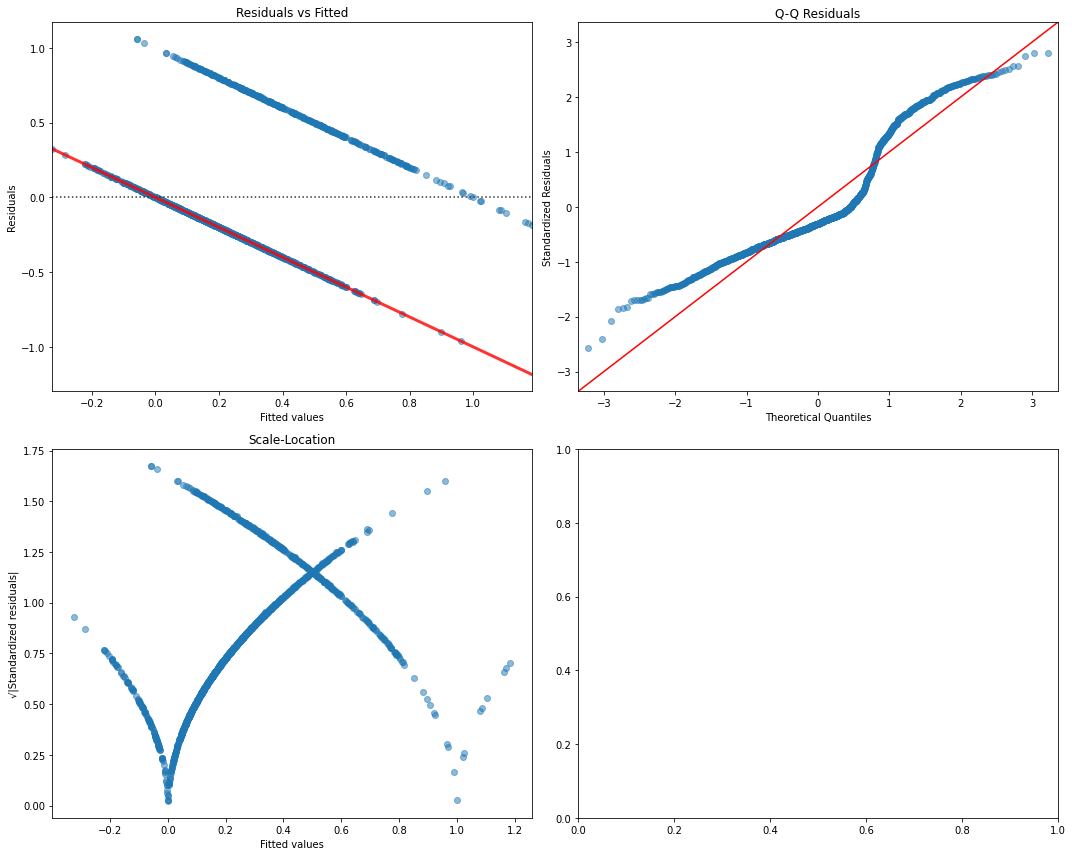

In [12]:
# Create a 2 by 2 subplot grid
model = linear_model
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# =============================================================================
# RESIDUALS VS FITTED
# =============================================================================
sns.residplot(
    x=model.fittedvalues,
    y=model.resid,
    lowess=True,
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red', 'lw': 3, 'alpha': 0.8},
    ax=axs[0, 0]
)

axs[0, 0].set_title('Residuals vs Fitted')
axs[0, 0].set_xlabel('Fitted values')
axs[0, 0].set_ylabel('Residuals')

# =============================================================================
# QQ PLOT
# =============================================================================
# Q-Q plot with standardized residuals
QQ = sm.ProbPlot(model.get_influence().resid_studentized_internal)
QQ.qqplot(line='45', alpha=0.5, lw=0.5, ax=axs[0, 1])
axs[0, 1].set_title('Q-Q Residuals')
axs[0, 1].set_xlabel('Theoretical Quantiles')
axs[0, 1].set_ylabel('Standardized Residuals')

# =============================================================================
# SCALE-LOCATION PLOT
# =============================================================================
standardized_resid = model.get_influence().resid_studentized_internal
axs[1, 0].scatter(model.fittedvalues, np.sqrt(np.abs(standardized_resid)), alpha=0.5)
axs[1, 0].set_title('Scale-Location')
axs[1, 0].set_ylabel('√|Standardized residuals|')
axs[1, 0].set_xlabel('Fitted values')


plt.tight_layout()
plt.show()

## Logistic Regression

In [13]:
logistic_model = sm.Logit(y_train, X_train).fit()
logistic_model.summary()

Optimization terminated successfully.
         Current function value: 0.435889
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Choice   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1590
Method:                           MLE   Df Model:                            9
Date:                Tue, 13 Feb 2024   Pseudo R-squ.:                  0.2249
Time:                        15:21:18   Log-Likelihood:                -697.42
converged:                       True   LL-Null:                       -899.74
Covariance Type:            nonrobust   LLR p-value:                 1.410e-81
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Gender              -0.9471      0.127     -7.451      0.000      -1.196      -0.698
Amount_purchased     0.0011      0.001      1.728      0.084      -0.000       0.002
Frequency           -0.0898      0.014     -6.270      0.000      -0.118      -0.062
Last_purchase        0.5919      0.093      6.365      0.000       0.410       0.774
First_purchase      -0.0090      0.012     -0.732      0.464      -0.033       0.015
P_Child             -0.8210      0.117     -7.027      0.000      -1.050      -0.592
P_Youth             -0.6520      0.144     -4.536      0.000      -0.934      -0.370
P_Cook              -0.9322      0.120     -7.797      0.000      -1.167      -0.698
P_DIY               -0.9160      0.144     -6.372      0.000      -1.198      -0.634
P_Art                0.6834      0.128      5.353      0.000       0.433       0.934
====================================================================================
"""

In [14]:
log_probs = logistic_model.predict(X_test)

In [15]:
log_preds = [1 if i >=.5 else 0 for i in logistic_model.predict(X_test )]

In [16]:
log_res, log_cm = evaluate(log_preds, y_test)


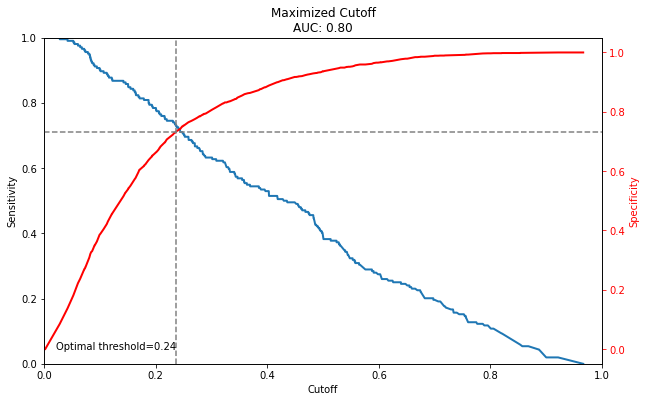

In [17]:
plot_sensitivity_specificity(y_test.values, log_probs)

In [18]:
opt_thres = .24

In [19]:
log_preds_opt_thresh = [1 if i >=opt_thres else 0 for i in logistic_model.predict(X_test )]

In [20]:
log_preds_res, log_preds_cm =  evaluate(log_preds_opt_thresh, y_test)

In [21]:
log_preds_res['name'] = 'log'
dict_results_lists.append(log_preds_res)

In [22]:
# SKLEARN
# logistic_model = LogisticRegression(
#     penalty=None,
#     solver = 'lbfgs',
#     max_iter=10000
# )
# logistic_model.fit(X_train,y_train)
# logistic_model.summary()

In [23]:
svc_model = svm.SVC()
svc_model.fit(bal_X_train,bal_y_train)

SVC()

In [24]:
svc_model = svm.SVC()

C_range = np.arange(0.1, 1.1, 0.1)  # Similar to seq(.1, 1, by = .1) in R
gamma_range = np.arange(0.01, 0.11, 0.01)  # Similar to seq(.01, .1, by = .01) in R


# Define parameters to search over
param_grid = {
    'C': C_range.tolist(),  # Convert numpy array to list for C values
    'gamma': gamma_range.tolist(),  # Convert numpy array to list for gamma values
    # Optionally, you can uncomment and adjust 'kernel' and 'degree' if needed
    # 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    # 'degree': [2, 3, 4],
}

# Setup GridSearchCV
grid_search = GridSearchCV(svc_model, param_grid, cv=5, verbose=2, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'C': 0.1, 'gamma': 0.01}
Best score found:  0.75


In [25]:
# Creating a new model with the best parameters
best_svc_model = svm.SVC(**grid_search.best_params_)

# Fitting the new model on the training data
best_svc_model.fit(X_train, y_train)

# Now, best_svc_model is ready to make predictions
svm_preds = best_svc_model.predict(X_test)

In [33]:
svm_res, svm_cm = evaluate(svm_preds, y_test)
svm_res['name'] = 'svm'
dict_results_lists.append(svm_res)

## LDA

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
lda = lda()
lda.fit(X_train_scaled,y_train)

X_test_scaled = scaler.transform(X_test)
lda_preds = lda.predict(X_test_scaled)

In [44]:
lda_res, lda_cm = evaluate(lda_preds, y_test)
lda_res['name'] = 'lda'
dict_results_lists.append(lda_res)

# Pretty Graph

In [45]:
results_df = pd.DataFrame(dict_results_lists)

In [46]:
dict_results_lists

[{'sensitivity': 0.7254901960784313,
  'specificity ': 0.7375954198473282,
  'accuracy': 0.7365217391304347,
  'name': 'log'},
 {'sensitivity': 0.0,
  'specificity ': 1.0,
  'accuracy': 0.9113043478260869,
  'name': 'svm'},
 {'sensitivity': 0.0,
  'specificity ': 1.0,
  'accuracy': 0.9113043478260869,
  'name': 'svm'},
 {'sensitivity': 0.0,
  'specificity ': 1.0,
  'accuracy': 0.9113043478260869,
  'name': 'svm'},
 {'sensitivity': 0.37745098039215685,
  'specificity ': 0.9389312977099237,
  'accuracy': 0.8891304347826087,
  'name': 'lda'}]

In [47]:
results_df

,sensitivity,specificity,accuracy,name
0,0.725490,0.737595,0.736522,log
1,0.000000,1.000000,0.911304,svm
2,0.000000,1.000000,0.911304,svm
3,0.000000,1.000000,0.911304,svm
4,0.377451,0.938931,0.889130,lda


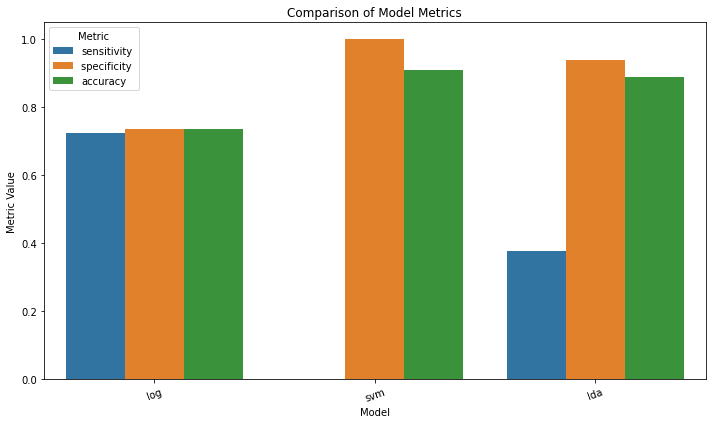

In [48]:
# Correcting the 'value_vars' parameter to match the DataFrame's column names
df_long = pd.melt(
    results_df,
    id_vars='name',
    value_vars=['sensitivity', 'specificity ', 'accuracy'],
    var_name='Metric',
    value_name='Value'
)
# Note the space in 'specificity ' to match the DataFrame's column name

# Continue with the plotting as before
plt.figure(figsize=(10, 6))
sns.barplot(data=df_long, x='name', y='Value', hue='Metric')

plt.xticks(rotation=20)  # Rotate x-axis labels for better readability
plt.title('Comparison of Model Metrics')
plt.xlabel('Model')
plt.ylabel('Metric Value')
plt.legend(title='Metric')

plt.tight_layout()
plt.show()